In [2]:
#!pip install seaborn
#!pip install wordcloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

# For reproducibility
np.random.seed(42)

from glob import glob
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

bce = tf.keras.losses.BinaryCrossentropy()
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.linear_model import LogisticRegression

In [3]:
tf.__version__, np.__version__

('2.4.1', '1.19.5')

In [4]:
# somehow Keras has issues with newer version of numpy so make sure its not >=1.20
#!pip install numpy==1.19.5

In [5]:
df = pd.read_csv('../metadata.csv')
df.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [6]:
df = df[df['modality']=='X-ray']

In [7]:
df['label'] = df['finding'].apply(lambda x: 1 if x=='Pneumonia/Viral/COVID-19' else 0)

In [8]:
df.shape

(866, 31)

In [9]:
df['label'].value_counts()

1    504
0    362
Name: label, dtype: int64

In [10]:
fnames = glob('../images/*')
fnames = [fname.split('/')[-1] for fname in fnames]

In [11]:
df_update = df[df['filename'].isin(fnames)]

In [12]:
df_update.shape

(866, 31)

## Other useful features

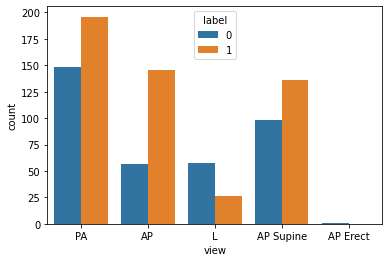

In [13]:
sns.countplot(x='view', hue = 'label', data=df_update)
plt.show()

## NLP part

In [14]:
notes = df[(~df['clinical_notes'].isna()) & (df['finding']=='Pneumonia/Viral/COVID-19')]['clinical_notes']
notes_text = ' '.join(notes.to_list())

In [15]:
word_cloud = WordCloud(max_font_size=40).generate(notes_text)

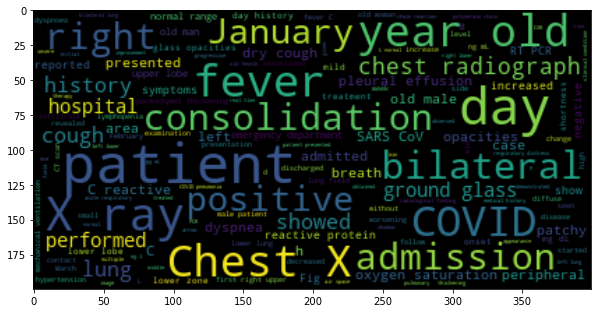

In [16]:
plt.figure(figsize=(10,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

#### Ideally we want to drop examples where the clinical text has COVID or SARS

In [17]:
df.shape

(866, 31)

In [18]:
#drop when the values are NULL or when they have covid/sars
df = df[~df['clinical_notes'].isna()]
df = df[~df['clinical_notes'].str.contains('covid|sars', case=False)]

In [19]:
df.shape

(514, 31)

#### Unique clinical notes

In [20]:
df['patientid'].nunique()

264

### NLP data processing

### Train test split
Cannot use regular train test split, information leakage can occur because of duplication in clinincal notes data, due to duplicate patient entries.

In [21]:
#X = df['clinical_notes']
#y = df['label']

In [22]:
#Seq_train, Seq_heldout, y_train, y_heldout = train_test_split(X, y, test_size=0.12, random_state=42, stratify=y)

In [23]:
#Seq_train, Seq_test, y_train, y_test = train_test_split(Seq_train, y_train, test_size=0.14, random_state=42, stratify=y_train)

### Train test split: on patient ID
Regular train test split cannot be used as we have multiple entries (rows) for the same patient. Ideally we should split by patientID to avoid information leakage

In [184]:
split_perc = 0.08
split_val = int(split_perc * df.shape[0])
patient_ids = df['patientid'].unique()
np.random.seed(10)
np.random.shuffle(patient_ids)
train_indices = patient_ids[2*split_val:]
heldout_indices = patient_ids[:split_val]
test_indices = patient_ids[split_val:2*split_val]

In [185]:
Seq_train = df[df['patientid'].isin(train_indices)]['clinical_notes'].values
y_train = df[df['patientid'].isin(train_indices)]['label'].values

In [186]:
Seq_test = df[df['patientid'].isin(test_indices)]['clinical_notes'].values
y_test = df[df['patientid'].isin(test_indices)]['label'].values

In [187]:
Seq_heldout = df[df['patientid'].isin(heldout_indices)]['clinical_notes'].values
y_heldout = df[df['patientid'].isin(heldout_indices)]['label'].values

In [188]:
y_train.shape, y_test.shape, y_heldout.shape

((356,), (86,), (72,))

### Vectorization
Used by the base model

In [189]:
vectorizer = CountVectorizer(min_df=0, lowercase=True)

In [190]:
#vectorizer.fit(df['clinical_notes'])
vectorizer.fit(Seq_train)

CountVectorizer(min_df=0)

In [191]:
len(vectorizer.vocabulary_)

2061

In [192]:
X_train = vectorizer.transform(Seq_train)

In [193]:
X_test = vectorizer.transform(Seq_test)

### Base model

In [194]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [195]:
score = clf.score(X_test, y_test)

In [196]:
print(score)

0.7674418604651163


## NLP model

In [197]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [198]:
tokenizer = Tokenizer(num_words=2500)
tokenizer.fit_on_texts(Seq_train)

In [199]:
X_train = tokenizer.texts_to_sequences(Seq_train)

In [200]:
X_test = tokenizer.texts_to_sequences(Seq_test)

In [201]:
vocab_size = len(tokenizer.word_index) + 1 #0 in reserved index so adding 1

In [205]:
print(Seq_train[45]) if isinstance(Seq_train, np.ndarray) else print(Seq_train.to_list()[45])
print(X_train[45])

Chest x-ray images and chest CT images from a 38-year-old man showing that there are small patchy ground glass like density increasing shadow in the upper and lower lobes of the left lung, with clear hilar structure, unobstructed trachea, no mediastinum displacement, no enlarged lymph node shadow, and no abnormality of pleura on both sides;
[8, 29, 30, 325, 2, 8, 53, 325, 70, 5, 327, 24, 23, 62, 247, 135, 60, 27, 102, 79, 81, 86, 280, 388, 389, 290, 6, 1, 33, 2, 18, 242, 3, 1, 13, 21, 4, 224, 198, 615, 1162, 311, 22, 624, 1163, 22, 422, 431, 770, 290, 2, 22, 390, 3, 1164, 9, 35, 771]


#### padding tokenized sequences

In [206]:
maxlen = 150

In [207]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)

In [208]:
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [209]:
X_train[0, :]

array([  92,   46,    8,   29,   30,  464,    9,  718,  237,  886,    1,
       1101,    3,   35,   57,   10,  339,    2,   85,   79,  373,   67,
        340, 1102,   67, 1103,    2,  289,   81,   86,  127,    2,  719,
        373,   67,  720,    9,    1,   18,   11,   20,  465,  466,  522,
        110,   88,    6,    1,  311,  111,  290, 1104,  721,    6,    1,
         36,  238,    9,    1,   13,  204,    1,  722,  723,   19,   59,
       1105, 1106,    1,   11,  204,    3,    1,  722,  723,   10, 1107,
          2, 1108,    2,  887, 1109,  523,   10,  467, 1110,    8,   29,
         30,    9,  718,  291,   37, 1111, 1112,  524,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [210]:
emb_dim = 100

In [267]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=maxlen))

#1. use simple flattening
#model.add(Flatten())

#2. use global maxpool
model.add(GlobalMaxPool1D())

#3. use LSTM, worst results for non patient ID based split
#model.add(LSTM(60))#, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(20, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [268]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 150, 100)          212400    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 21        
Total params: 214,441
Trainable params: 214,441
Non-trainable params: 0
_________________________________________________________________


In [269]:
# model_res = model.fit(X_train, y_train,
#                     epochs=40,
#                     verbose=1,
#                     validation_data=(X_test, y_test),
#                     batch_size=16)

In [270]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
batch_size = 16

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts_nlp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_res = model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(X_test, y_test))

Epoch 1/20
23/23 [==============================] - 1s 15ms/step - loss: 0.6948 - accuracy: 0.4878 - auc_18: 0.5100 - val_loss: 0.6864 - val_accuracy: 0.8372 - val_auc_18: 0.8963
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.9163 - auc_18: 0.9845 - val_loss: 0.6753 - val_accuracy: 0.8721 - val_auc_18: 0.9435
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.9160 - auc_18: 0.9935 - val_loss: 0.6614 - val_accuracy: 0.6977 - val_auc_18: 0.9397
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5932 - accuracy: 0.9736 - auc_18: 0.9967 - val_loss: 0.6219 - val_accuracy: 0.8837 - val_auc_18: 0.9509
Epoch 5/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5134 - accuracy: 0.9947 - auc_18: 0.9973 - val_loss: 0.5611 - val_accuracy: 0.9070 - val_auc_18: 0.9591
Epoch 6/20
23/23 [==============================] - 0s 4ms/step - loss: 0.3945 - accuracy: 0.9892 - auc_18: 0

In [271]:
preds = model.predict(X_test).round()

In [272]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        39
           1       0.88      0.94      0.91        47

    accuracy                           0.90        86
   macro avg       0.90      0.89      0.89        86
weighted avg       0.90      0.90      0.89        86



In [273]:
confusion_matrix(y_test, preds)

array([[33,  6],
       [ 3, 44]])

In [274]:
model = tf.keras.models.load_model('.mdl_wts_nlp.hdf5')

In [275]:
preds = model.predict(X_test).round()

In [276]:
confusion_matrix(y_test, preds)

array([[33,  6],
       [ 3, 44]])

In [277]:
loss, accuracy, auc = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}, Training AUC: {:.2f}".format(accuracy, auc))
loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}, Testing AUC: {:.2f}".format(accuracy, auc))

Training Accuracy: 0.9972, Training AUC: 1.00
Testing Accuracy:  0.8953, Testing AUC: 0.96
